# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

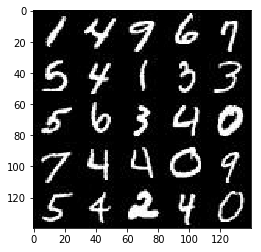

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

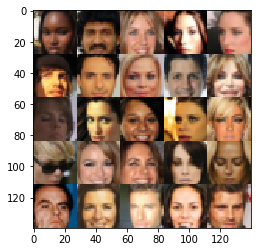

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    noise_vector = tf.placeholder(tf.float32, [None, z_dim], name="noise_vector")
    l_rate = tf.placeholder(tf.float32, None, name="l_rate")

    return real_input, noise_vector, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):    
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flatten = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 3, 1, 'same', activation=None)
        output = tf.tanh(logits)
    
        return output
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen_output = generator(input_z, out_channel_dim)
    d_output, d_logits = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(gen_output, reuse=True)
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    
    d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits, labels=tf.ones_like(d_output)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    
    d_loss_total = d_loss + d_loss_fake
    
    return d_loss_total, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
   
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_training_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_training_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return d_training_opt, g_training_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Define shape of data provided to the model
    _, width, height, n_channels = data_shape
    
    # Based on the shape of the data, define TensorFlow placeholders that 
    # will be used to feed data into the model
    real_input, noise_vector, l_rate = model_inputs(width, height, n_channels, z_dim)
    
    # Define how loss is calculated for both nets in the model
    d_loss_total, gen_loss = model_loss(real_input, noise_vector, n_channels)
    
    # Create optimizers for both nets in the model
    d_training_opt, g_training_opt = model_opt(d_loss_total, gen_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model 
                steps += 1
                batch_images *= 2
                
                # Sample noise for generator:
                noise_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_training_opt, feed_dict={real_input: batch_images, noise_vector: noise_sample, l_rate: learning_rate})
                _ = sess.run(g_training_opt, feed_dict={real_input: batch_images, noise_vector: noise_sample, l_rate: learning_rate})
                
                # Print generator and discriminator losses every 10 steps
                # Print generator output every 100 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss_total.eval({noise_vector: noise_sample, real_input: batch_images})
                    train_loss_g = gen_loss.eval({noise_vector: noise_sample})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 20, noise_vector, n_channels, data_image_mode)
                        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0485... Generator Loss: 24.9161
Epoch 1/2... Discriminator Loss: 0.0369... Generator Loss: 11.8171
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 12.2564
Epoch 1/2... Discriminator Loss: 1.8028... Generator Loss: 8.3080
Epoch 1/2... Discriminator Loss: 0.3146... Generator Loss: 2.2604
Epoch 1/2... Discriminator Loss: 3.8812... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 0.3517... Generator Loss: 1.9232
Epoch 1/2... Discriminator Loss: 0.0480... Generator Loss: 8.3278
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 3.6484
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.9463


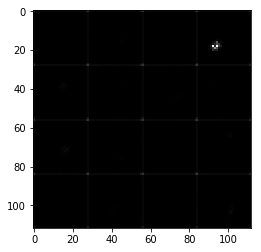

Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 2.4329... Generator Loss: 0.1222
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 2.4422
Epoch 1/2... Discriminator Loss: 1.7043... Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 0.2828
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 0.9934
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 2.3239
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 1.3182


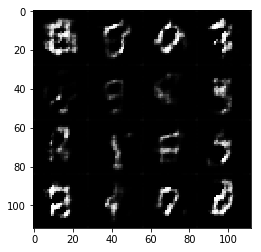

Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 2.3478
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 1.4788
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.3396


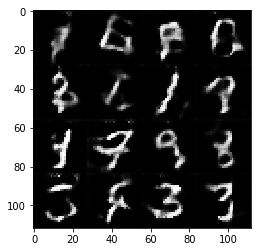

Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 1.4872
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.4419
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.3760
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 1.9780


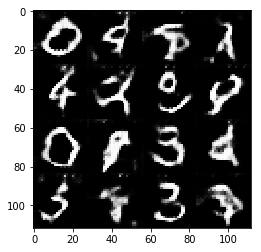

Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.4027


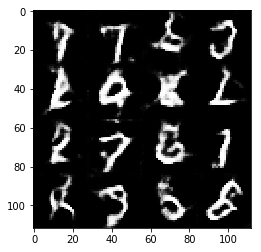

Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.4462
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.9976
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.3423
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.6225


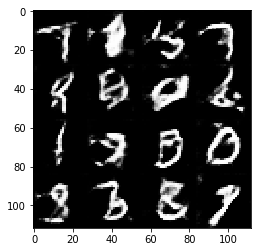

Epoch 1/2... Discriminator Loss: 1.6233... Generator Loss: 0.3430
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.2722
Epoch 1/2... Discriminator Loss: 1.5277... Generator Loss: 0.3173


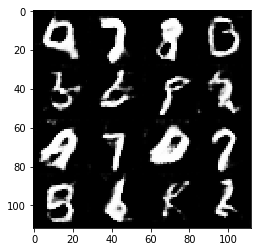

Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.3591
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.3005
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 1.5735


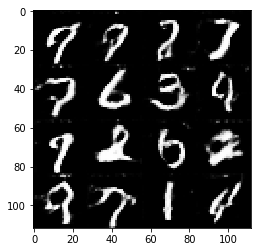

Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 0.3184
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.8336... Generator Loss: 1.3069


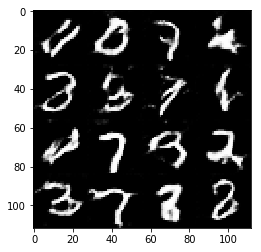

Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 1.9380... Generator Loss: 0.2212
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.9443... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 1.5648
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 0.7522


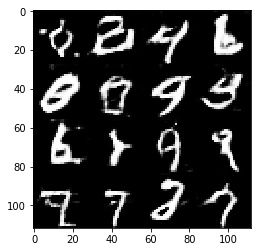

Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.9911
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.4124
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 0.9918... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 1.8241... Generator Loss: 0.2318
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.7088


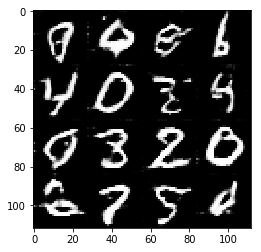

Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.5554... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.5367
Epoch 1/2... Discriminator Loss: 2.2114... Generator Loss: 0.1452
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.2571


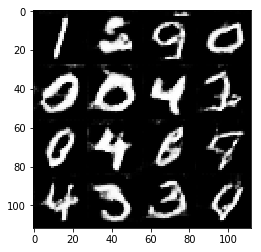

Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 0.9394... Generator Loss: 1.4038
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.3319
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 0.3384


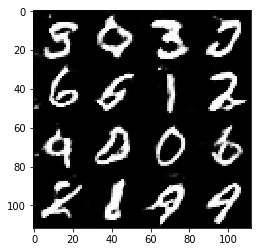

Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.7954... Generator Loss: 0.2575
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.3483
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.4419


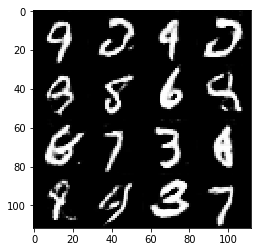

Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.4313
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.8562
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 1.3316
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.7636


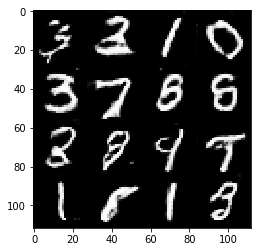

Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 0.6589... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.6334... Generator Loss: 2.9132
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 0.9275
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.4481


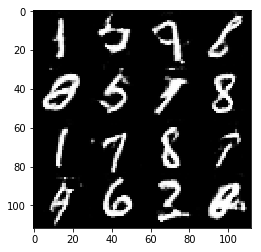

Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 2.1109... Generator Loss: 0.2065
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 1.4775
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.1013
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 0.7152


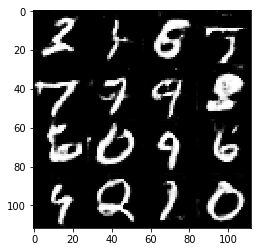

Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 1.2529
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.0956


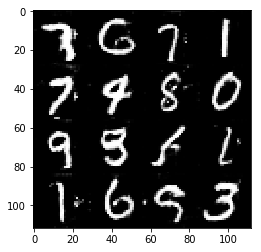

Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.4327
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.4438
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.3880
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 1.4237
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 1.4205
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 0.9826


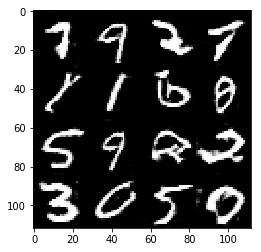

Epoch 2/2... Discriminator Loss: 2.0549... Generator Loss: 0.1836
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.0563
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.5216... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 1.3225
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 0.7964


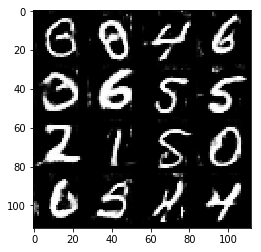

Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 2.4613
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 2.4217... Generator Loss: 0.1223
Epoch 2/2... Discriminator Loss: 1.5703... Generator Loss: 0.4106
Epoch 2/2... Discriminator Loss: 1.8044... Generator Loss: 0.2556
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 1.8470... Generator Loss: 0.2278
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 1.9469


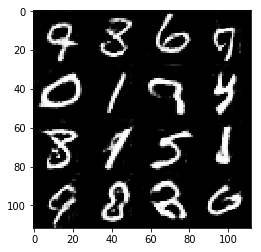

Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 2.1056
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.4248
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.5270
Epoch 2/2... Discriminator Loss: 1.6202... Generator Loss: 0.3218
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.3769
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 0.7049


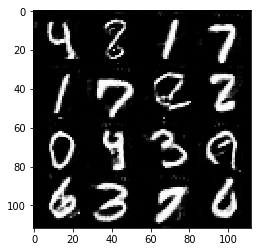

Epoch 2/2... Discriminator Loss: 1.7647... Generator Loss: 0.2875
Epoch 2/2... Discriminator Loss: 1.4452... Generator Loss: 0.4279
Epoch 2/2... Discriminator Loss: 1.7563... Generator Loss: 0.2811
Epoch 2/2... Discriminator Loss: 1.8202... Generator Loss: 0.2453
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.5930... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.4687


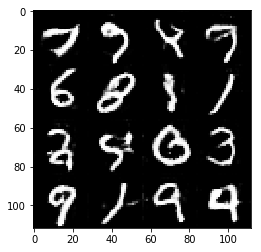

Epoch 2/2... Discriminator Loss: 3.1522... Generator Loss: 3.8634
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 1.3599
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.3804
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 1.5440
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.4028
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 2.4325


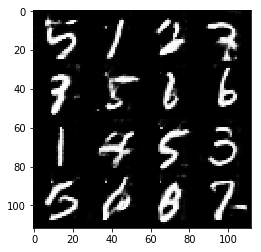

Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 1.6657... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 1.9010... Generator Loss: 2.6499
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.7249
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.3299
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.3985


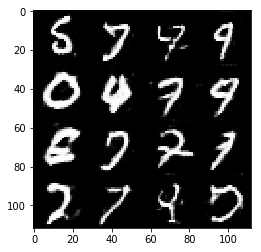

Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.2419
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 2.8309... Generator Loss: 3.2998
Epoch 2/2... Discriminator Loss: 1.7562... Generator Loss: 0.2582
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 3.1084
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.4398


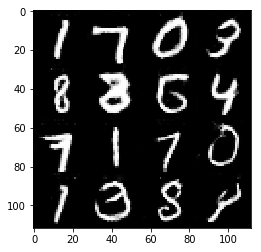

Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.4175
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.5991
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 1.0638
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.3124
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.6922


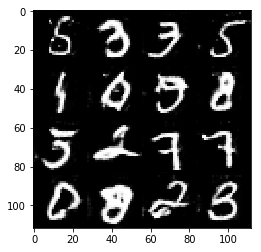

Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.4874
Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.9336
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 1.2699
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 2.2036
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 0.9292


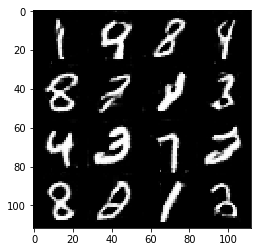

Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 2.6459
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.8769
Epoch 2/2... Discriminator Loss: 2.2308... Generator Loss: 0.1745
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.0232


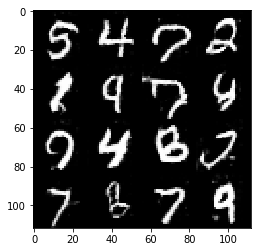

Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 3.5427
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.5214
Epoch 2/2... Discriminator Loss: 1.9270... Generator Loss: 0.2848
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 2.2133


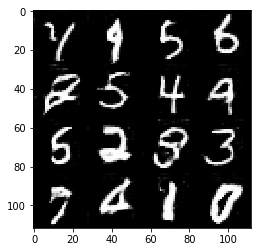

Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.7264... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.5028
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.5607
Epoch 2/2... Discriminator Loss: 1.7729... Generator Loss: 0.2864


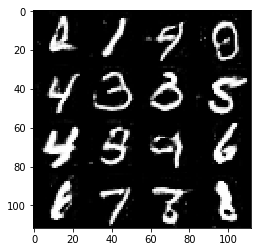

Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 1.3362
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.4592
Epoch 2/2... Discriminator Loss: 2.1247... Generator Loss: 0.2268
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.1778
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.4990
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 1.3921


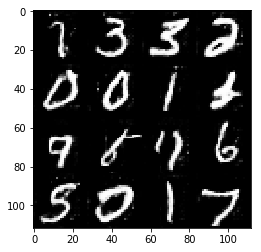

Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 1.5882
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 2.0958
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.6418
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 1.1618


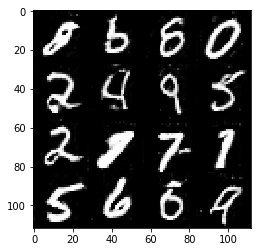

Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.4113
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.4782
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 1.8907
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 2.2415... Generator Loss: 0.1744


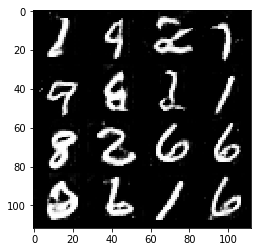

Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 2.2787
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 2.3134... Generator Loss: 0.1512
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 2.3472
Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.2127


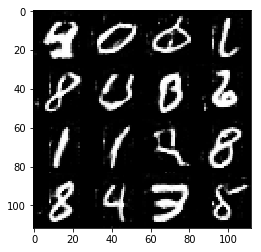

Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 1.5247
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 1.3408
Epoch 2/2... Discriminator Loss: 1.7132... Generator Loss: 0.3049
Epoch 2/2... Discriminator Loss: 1.5836... Generator Loss: 3.6844
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.7919
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 1.7691
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 1.9554


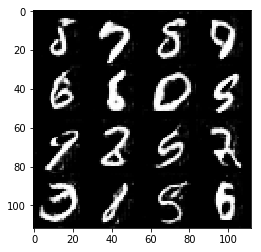

Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.3967
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 1.1584
Epoch 2/2... Discriminator Loss: 0.6437... Generator Loss: 1.3435
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.8783
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 2.9725... Generator Loss: 0.0950
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 1.7640
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.3854


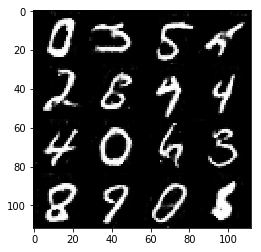

Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 2.2361
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 1.5413
Epoch 2/2... Discriminator Loss: 0.2096... Generator Loss: 3.2132
Epoch 2/2... Discriminator Loss: 0.5267... Generator Loss: 1.5930
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.7952


In [45]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.8016
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 16.9912
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 6.2707
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 3.1162... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.9750
Epoch 1/1... Discriminator Loss: 2.1967... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 3.7529
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.7701


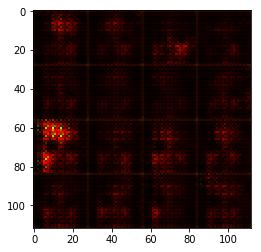

Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 4.7788
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.3954


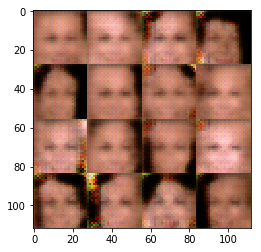

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 1.7169
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 2.0026... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.2059


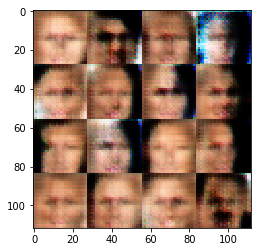

Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5878


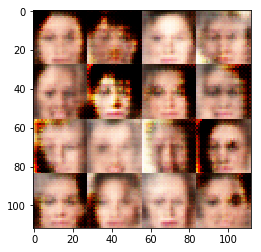

Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.6997... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6997


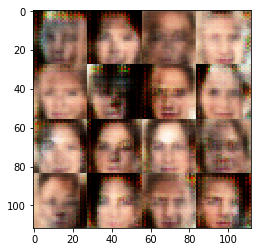

Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 0.2249
Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.8844


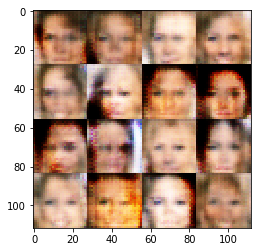

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.2410
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 2.0487... Generator Loss: 0.1694
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.7745... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 3.0643... Generator Loss: 3.5635


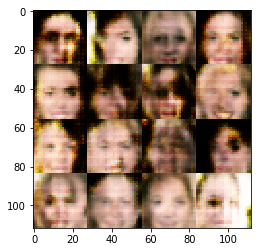

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.5584
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.4860


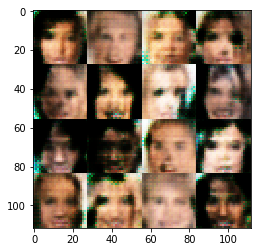

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.6991
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8520


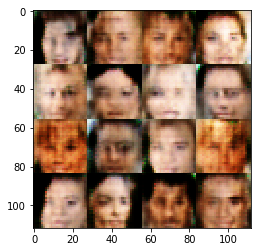

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6810


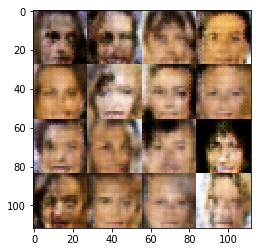

Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6940


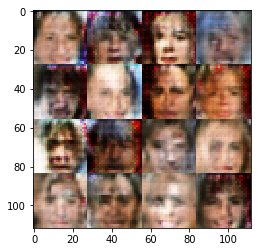

Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 1.7331... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.7802


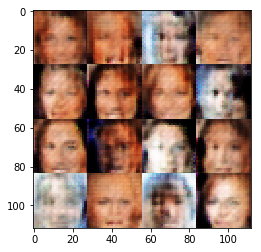

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.3528
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8859


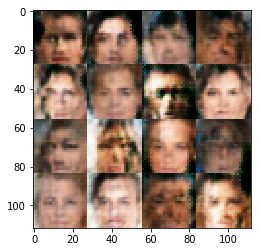

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 2.0859
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.7774... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6918


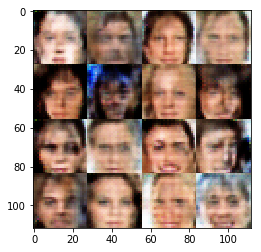

Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8305


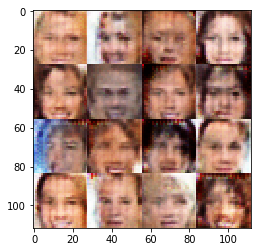

Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9970


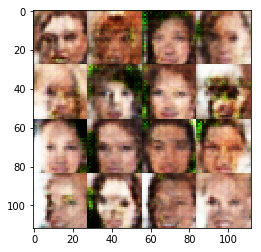

Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7871


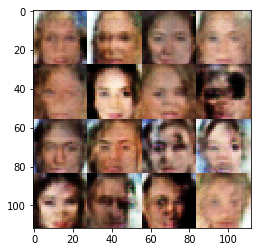

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.0916


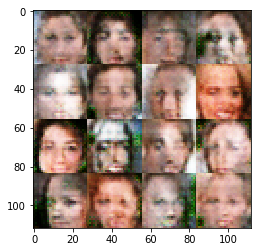

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6078


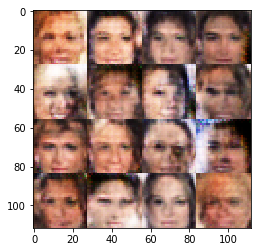

Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.4509


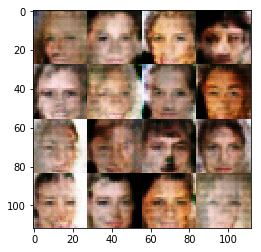

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6422


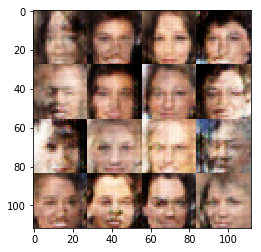

Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6558


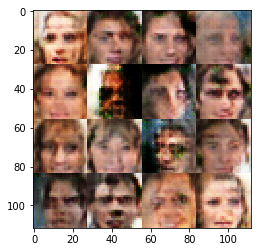

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5791


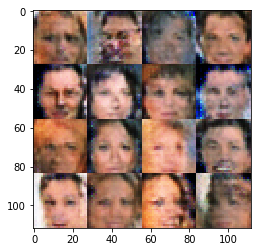

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4592


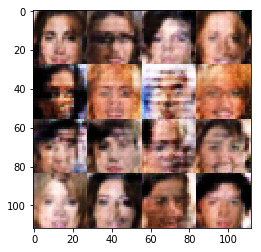

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7812


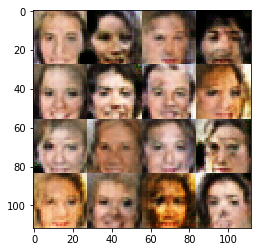

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6175


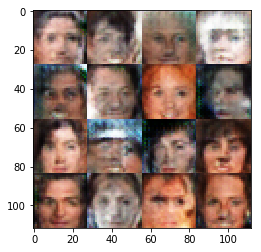

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.6311


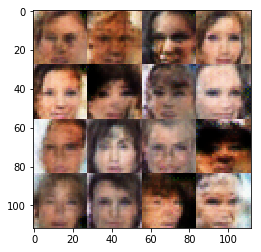

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.5896


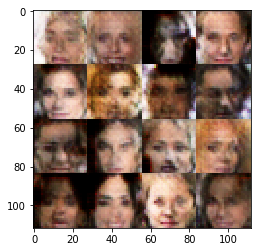

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7823


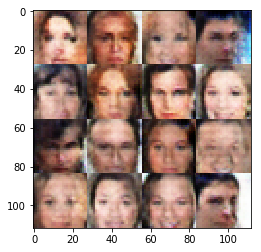

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.5787


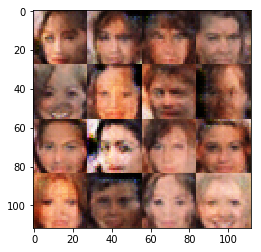

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8398


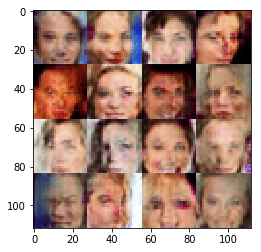

Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.6907


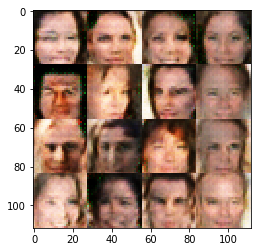

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6466


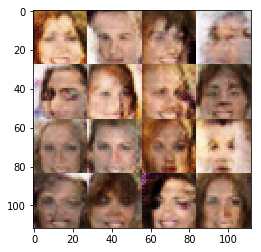

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7476


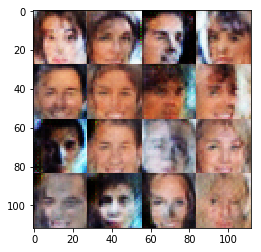

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5387


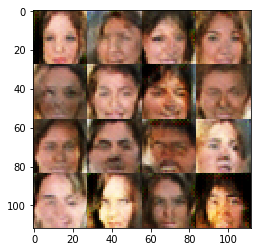

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6953


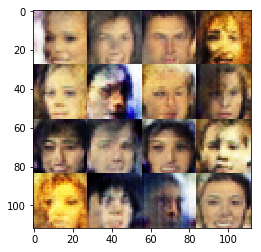

Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7411


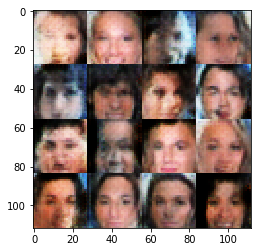

Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6769


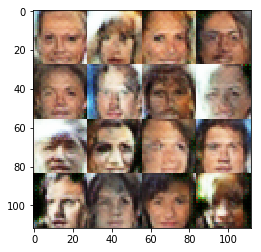

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7092


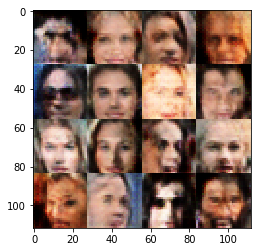

Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.5362


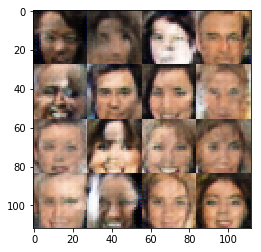

Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5956


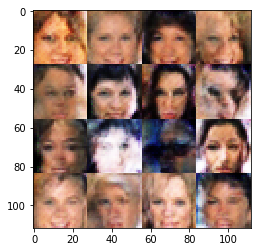

Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6983


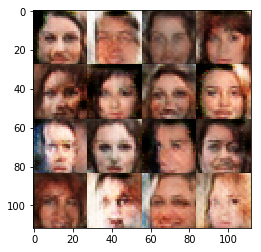

Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.6402


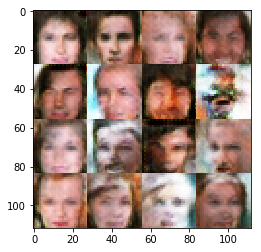

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6589


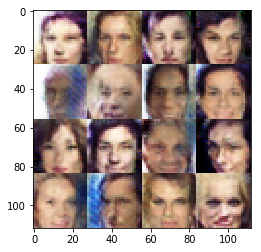

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8718


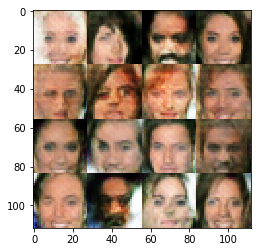

Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6348


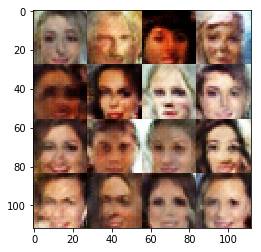

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5941


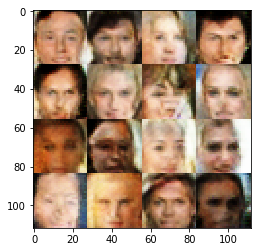

Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7469


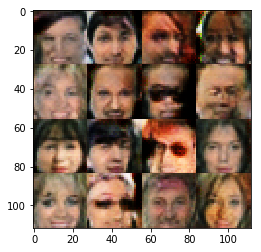

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.5742


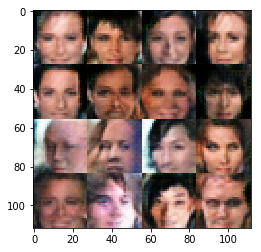

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.4917


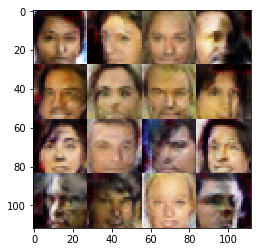

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6700


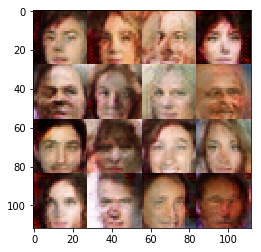

Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.5772


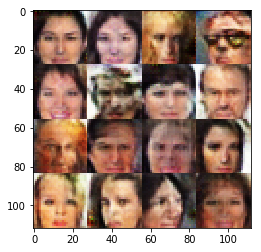

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7759


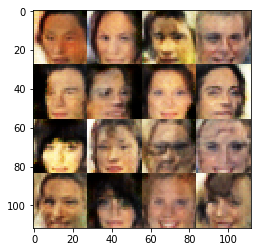

Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7923


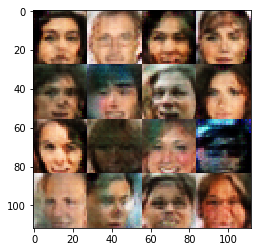

Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6318


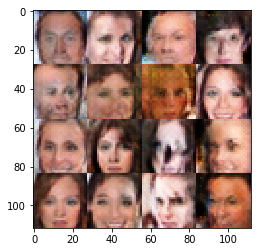

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7600


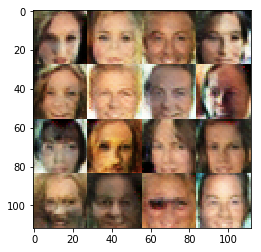

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.5860


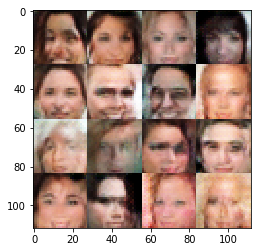

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.5906


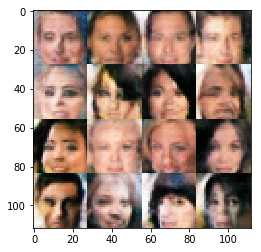

Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6665


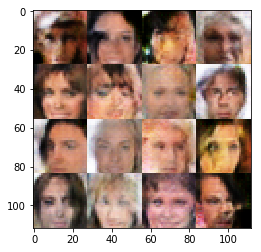

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.5420


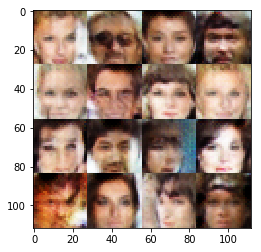

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6946


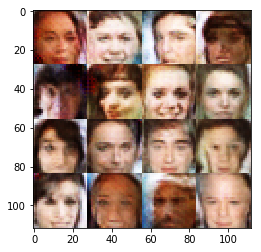

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7002


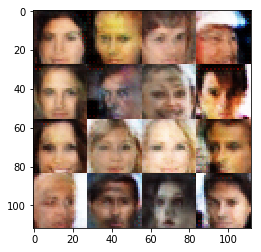

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5443


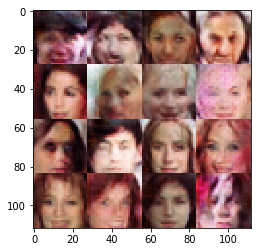

Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6045


In [46]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)